# LFV Higgs decays in SeeSaw model ( Thao et al results) First numeric results no compatibles con seesaw new discussions.

## In this notebook we use the mpmath implementations of PaVe functions

In [1]:
from sympy import init_printing, Symbol,lambdify, symbols, Matrix
init_printing()
import OneLoopLFVHD as lfvhd

In [2]:
from seesaw_FF import TrianglesOneFermion, TrianglesTwoFermion, Bubbles,DiagramsOneFermionW, DiagramsOneFermionG
from seesaw_FF import g, mW, Uν, Uνc, mn, m, C, Cc, a,b,i,j,h
from seesaw_FF import j as jj

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from mpmath import *

In [5]:
mp.dps = 80; mp.pretty = True

In [6]:
import numpy as np

In [7]:
import subprocess as s

In [8]:
from multiprocessing import Pool
from time import time

In [9]:
def speedup_array(f,array,procs=4): 
    pool = Pool(procs,maxtasksperchild=100).map(f, array)
    result = np.array(list(pool))
    return result

## Numeric implementation of form factors

**Neutrino benchmark** is given by 

In [10]:
from OneLoopLFVHD.neutrinos import NuOscObservables
Nudata = NuOscObservables

In [11]:
m1 = mpf('1e-12')  #GeV 

#current values to Square mass differences
d21 = mpf(str(Nudata.squareDm21.central))*mpf('1e-18')# factor to convert eV^2 to GeV^2
d31 = mpf(str(Nudata.squareDm31.central))*mpf('1e-18')

#d21 = 7.5e-5*1e-18
#d31 = 2.457e-3*1e-18
m2 = sqrt(m1**2 + d21)
m3 = sqrt(m1**2 + d31)

m4 = lambda m6: m6/3
m5 = lambda m6: m6/2

### Form factor with one fermion in the loop.

#### AL one fermion 

In [12]:
from OneLoopLFVHD.data import ml

In [13]:
def GIM_One(exp):
    from sympy import Add
    args = exp.expand().args
    func = exp.expand().func
    if isinstance(func,Add):
        X = Add(*[t for t in args if t.has(mni)]).simplify()
    else:
        X = exp
    #X1 = X.collect([mni],evaluate=False)
    return X#mni**2*X1[mni**2]

In [14]:
def sumOne(m6,Aab,a,b): 
    mnk = [m1,m2,m3,m6/3,m6/2,m6]
    AL = []
    for k in range(4,7):
        A = Aab(mnk[k-1],Unu(m1,m6,b,k),conj(Unu(m1,m6,a,k)))
        #print('Ai = ',A)
        AL.append(A)
    return mp.fsum(AL)


In [15]:
mh,ma,mb = symbols('m_h,m_a,m_b',real=True)
valores ={mW:mpf('80.379'),mh:mpf('125.10'),g:(2*mpf('80.379'))/mpf('246')}

cambios_hab = lambda a,b:{lfvhd.ma:valores[mh],lfvhd.mi:ml[a],lfvhd.mj:ml[b]}


Ubi, Ucai,mni = symbols('U_{bi}, {{U_{ai}^*}},m_{n_i}')
UnuOne = {mn[i]:mni,Uν[b,i]:Ubi,Uνc[a,i]:Ucai}

from Unu_seesaw import Upmns_mp
from Unu_seesaw import Unump as Unu # no mixing
from Unu_seesaw import Cijmp as Cij # no mixing

In [16]:
from OneLoopLFVHD.data import replaceBs, pave_functions

In [17]:
def numeric_sum_diagramsOne(a,b,quirality='L'):
    FdiagOneFer = []
    for Set in [TrianglesOneFermion,Bubbles]:#TrianglesOneFermion,Bubbles
        for dia in Set:
            if quirality=='L':
                x = dia.AL().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            elif quirality=='R':
                x = dia.AR().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            else:
                raise ValueError('quirality must be L or R')
            f = lambdify([mni,Ubi,Ucai],replaceBs(x),
                         modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'])
            #print(f(1,2,3))
            #fsum = lambda m6:sumOne(m6,f,a,b)
            FdiagOneFer.append(f)
    def suma(m6):
        out = []
        xs = []
        for g in FdiagOneFer:
            
            x = sumOne(m6,g,a,b)
            out.append(x)
            xs.append(x)
        return np.array(xs), mp.fsum(out)
    return suma

In [18]:
# #a = 2, b = 3
# ALOneTot23 = numeric_sum_diagramsOne(2,3,quirality='L')
# AROneTot23 = numeric_sum_diagramsOne(2,3,quirality='R')

# #a = 3, b = 2
# ALOneTot32 = numeric_sum_diagramsOne(3,2,quirality='L')
# AROneTot32 = numeric_sum_diagramsOne(3,2,quirality='R')

# #a = 1, b = 3
# ALOneTot13 = numeric_sum_diagramsOne(1,3,quirality='L')
# AROneTot13 = numeric_sum_diagramsOne(1,3,quirality='R')

# #a = 3, b = 1
# ALOneTot31 = numeric_sum_diagramsOne(3,1,quirality='L')
# AROneTot31 = numeric_sum_diagramsOne(3,1,quirality='R')

# #a = 1, b = 2
# ALOneTot12 = numeric_sum_diagramsOne(1,2,quirality='L')
# AROneTot12 = numeric_sum_diagramsOne(1,2,quirality='R')

# #a = 2, b = 1
# ALOneTot21 = numeric_sum_diagramsOne(2,1,quirality='L')
# AROneTot21 = numeric_sum_diagramsOne(2,1,quirality='R')

In [19]:
def ALOneTot23(m6):
    return numeric_sum_diagramsOne(2,3,quirality='L')(m6)[1]
def AROneTot23(m6):
    return numeric_sum_diagramsOne(2,3,quirality='R')(m6)[1]

def ALOneTot32(m6):
    return numeric_sum_diagramsOne(3,2,quirality='L')(m6)[1]
def AROneTot32(m6):
    return numeric_sum_diagramsOne(3,2,quirality='R')(m6)[1]

def ALOneTot13(m6):
    return numeric_sum_diagramsOne(1,3,quirality='L')(m6)[1]
def AROneTot13(m6):
    return numeric_sum_diagramsOne(1,3,quirality='R')(m6)[1]

def ALOneTot31(m6):
    return numeric_sum_diagramsOne(3,1,quirality='L')(m6)[1]
def AROneTot31(m6):
    return numeric_sum_diagramsOne(3,1,quirality='R')(m6)[1]

def ALOneTot12(m6):
    return numeric_sum_diagramsOne(1,2,quirality='L')(m6)[1]
def AROneTot12(m6):
    return numeric_sum_diagramsOne(1,2,quirality='R')(m6)[1]

def ALOneTot21(m6):
    return numeric_sum_diagramsOne(2,1,quirality='L')(m6)[1]
def AROneTot21(m6):
    return numeric_sum_diagramsOne(2,1,quirality='R')(m6)[1]

In [20]:
n = 100
expmp = linspace(-1,6,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)

In [21]:
%%time
YLOne23 = speedup_array(ALOneTot23,m6np)
YLOne32 = speedup_array(ALOneTot32,m6np)

YLOne13 = speedup_array(ALOneTot13,m6np)
YLOne31 = speedup_array(ALOneTot31,m6np)

YLOne12 = speedup_array(ALOneTot12,m6np)
YLOne21 = speedup_array(ALOneTot21,m6np)

CPU times: user 869 ms, sys: 495 ms, total: 1.36 s
Wall time: 8min 11s


In [22]:
# #m6np = np.linspace(1e-10,1e8,n)

# YLOne23 = np.array([np.abs(ALOneTot23(mpf(m6))[1]) for m6 in m6np])
# YLOne32 = np.array([np.abs(ALOneTot32(mpf(m6))[1])for m6 in m6np])

# YLOne13 = np.array([np.abs(ALOneTot13(mpf(m6))[1])for m6 in m6np])
# YLOne31 = np.array([np.abs(ALOneTot31(mpf(m6))[1])for m6 in m6np])

# YLOne12 = np.array([np.abs(ALOneTot12(mpf(m6))[1])for m6 in m6np])
# YLOne21 = np.array([np.abs(ALOneTot21(mpf(m6))[1])for m6 in m6np])

In [23]:
factor = valores[mh]/(8*pi)

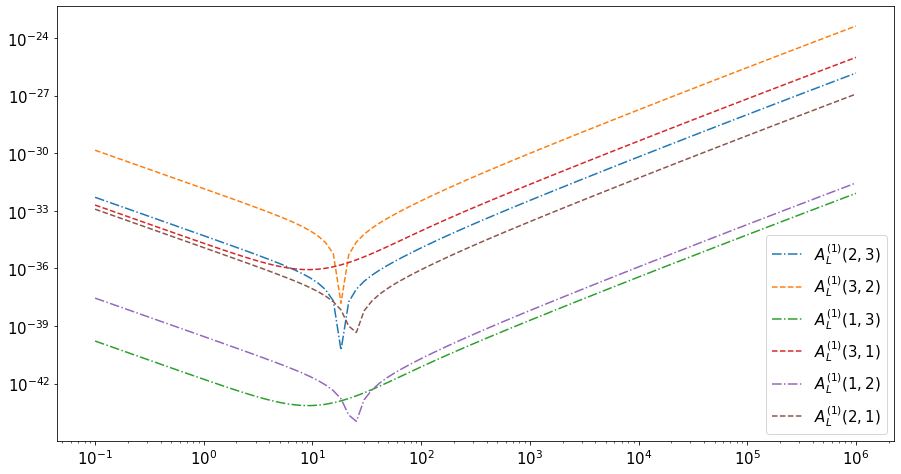

In [24]:
plt.figure(figsize=(15,8))
plt.loglog(np.real(m6np),factor*abs(YLOne23)**2,'-.',label='$A_L^{(1)}(2,3)$')
plt.loglog(np.real(m6np),factor*abs(YLOne32)**2,'--',label='$A_L^{(1)}(3,2)$')

plt.loglog(np.real(m6np),factor*abs(YLOne13)**2,'-.',label='$A_L^{(1)}(1,3)$')
plt.loglog(np.real(m6np),factor*abs(YLOne31)**2,'--',label='$A_L^{(1)}(3,1)$')

plt.loglog(np.real(m6np),factor*abs(YLOne12)**2,'-.',label='$A_L^{(1)}(1,2)$')
plt.loglog(np.real(m6np),factor*abs(YLOne21)**2,'--',label='$A_L^{(1)}(2,1)$')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

In [25]:
def contributions(m6np,fone):
    sumas = []
    diagramas = []
    for m6 in m6np:
        dias,suma = fone(mpf(m6))
        diagramas.append(dias)
        sumas.append(suma)
    return np.array(diagramas),np.array(sumas)
    

In [26]:
n = 100
expmp = linspace(1,3,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)

In [27]:
diaL23, YLOne23 = contributions(m6np,numeric_sum_diagramsOne(2,3,quirality='L'))
#diaL32, YLOne32 = contributions(m6np,ALOneTot32)

diaL13, YLOne13 = contributions(m6np,numeric_sum_diagramsOne(1,3,quirality='L'))
#diaL31, YLOne31 = contributions(m6np,ALOneTot31)

diaL12, YLOne12 = contributions(m6np,numeric_sum_diagramsOne(1,3,quirality='L'))
#diaL21, YLOne21 = contributions(m6np,ALOneTot21)

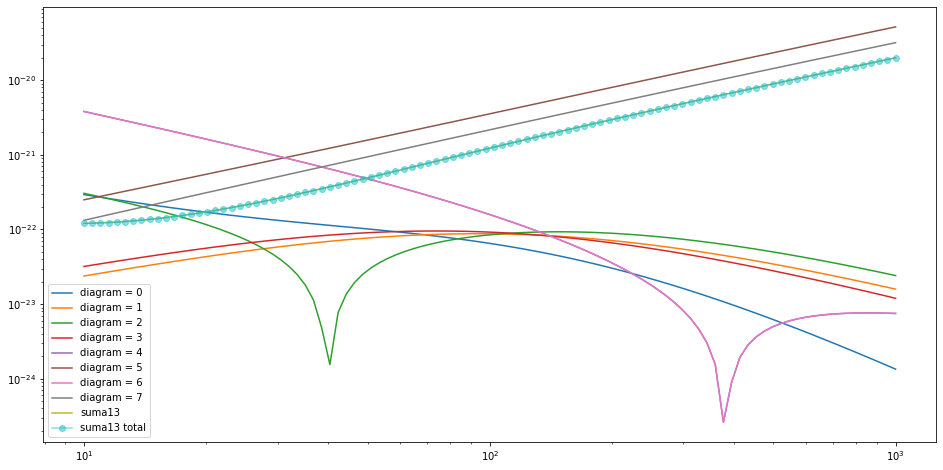

In [31]:
plt.figure(figsize=(16,8))
suma = 0.0
for k in range(8):
    r = diaL13[:,k]
    suma += r
    plt.loglog(m6np,np.abs(r),label=f'diagram = {k}')

plt.loglog(m6np,np.abs(suma),label='suma13')
plt.loglog(m6np,np.abs(YLOne13),'o-',label='suma13 total',alpha=0.5)
plt.legend()

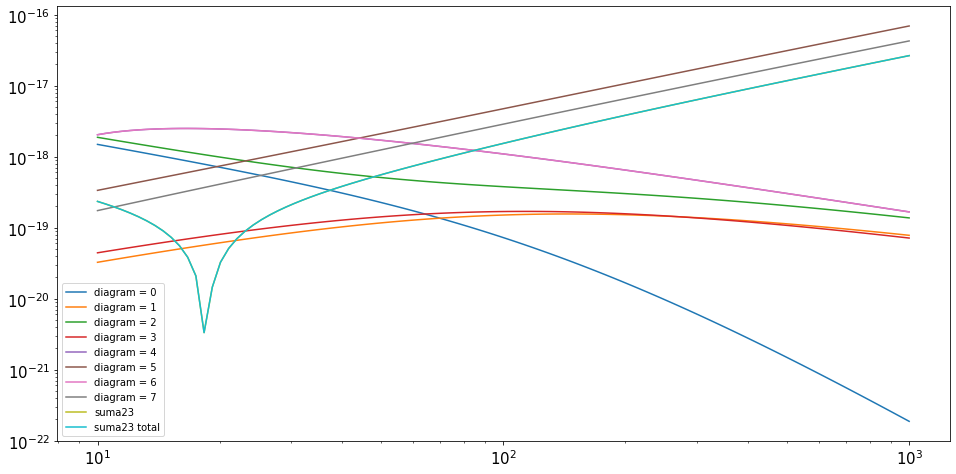

In [32]:
plt.figure(figsize=(16,8))
suma = 0.0
for k in range(8):
    r = diaL23[:,k]
    suma += r
    plt.loglog(m6np,np.abs(r),label=f'diagram = {k}')

plt.loglog(m6np,np.abs(suma),label='suma23')
plt.loglog(m6np,np.abs(YLOne23),label='suma23 total')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend()

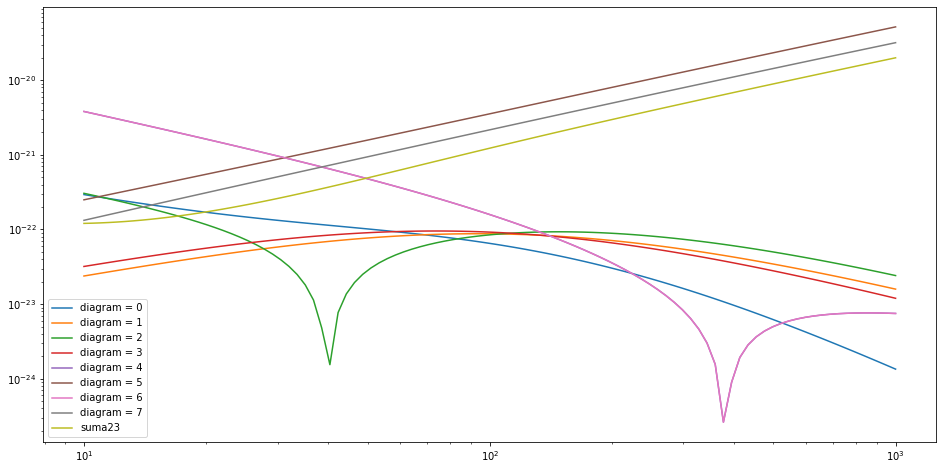

In [33]:
plt.figure(figsize=(16,8))
for k in range(8):
    plt.loglog(m6np,np.abs(diaL12[:,k]),label=f'diagram = {k}')

plt.loglog(m6np,np.abs(YLOne12),label='suma23')
plt.legend()

In [38]:
# mm6 = 1e8
# for p in range(1,7):
#     print(Unu(1e-12,mm6,3,p)*conj(Unu(1e-12,mm6,2,p)))

### Form factor with two fermion in the loop.

In [20]:
def sumTwo(m6,ALab,a,b): #m4 = m6/3,m5 = m6/2
    AL = []
    mnk = (m1,m2,m3,m4(m6),m5(m6),m6)
    for i in range(1,7):
        for j in range(1,7):
            #if i!=j and i<j:
            L = ALab(mnk[i-1],mnk[j-i],Unu(m1,m6,b,j),conj(Unu(m1,m6,a,i)),
                      Cij(m1,m6,i,j),conj(Cij(m1,m6,i,j)))
            if mp.isnan(L):
                print(mnk[i-1],mnk[j-i],Unu(m1,m6,b,j),Cij(m1,m6,i,j),L)
            AL.append(L)
    return mp.fsum(AL)

In [31]:
#TrianglesTwoFermion[0].AL().expand().collect([lfvhd.B12_0(mn[i],mn[jj])])

In [21]:
mnj = symbols('m_{n_j}',positive=True)
Cijs, Cijcs, Ubj = symbols('C_{ij}, {{C_{ij}^*}},U_{bj}')
UnuTwo = {mn[i]:mni,mn[jj]:mnj,C[i,jj]:Cijs, Cc[i,jj]:Cijcs, Uν[b,jj]:Ubj, Uνc[a,i]:Ucai}
UnuTwo

In [22]:
def numeric_sum_diagramsTwo(aa,bb,quirality='L'):
    FdiagTwoFer = []
    for dia in TrianglesTwoFermion:
        if quirality=='L':
            x = dia.AL().subs(lfvhd.D,4).subs(cambios_hab(aa,bb)).subs(valores).subs(UnuTwo)
        elif quirality=='R':
            x = dia.AR().subs(lfvhd.D,4).subs(cambios_hab(aa,bb)).subs(valores).subs(UnuTwo)
        else:
            raise ValueError('quirality must be L or R')
        f = lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(x),
                     modules=[pave_functions(valores[mh],aa,bb,lib='mpmath'),'mpmath'] )
        
        fsum = lambda m6:sumTwo(m6,f,aa,bb)
        FdiagTwoFer.append(fsum)
    return lambda m6: mp.fsum([f(m6) for f in FdiagTwoFer])

In [23]:
fsL = lambda k,a,b:TrianglesTwoFermion[k].AL().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)
fsR = lambda k,a,b:TrianglesTwoFermion[k].AR().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)

In [24]:
fL = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsL(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'] )
fR = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsR(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'] )

In [25]:
def sumatwo(mm6,k,a,b,quirality='L'):
    xs = []
    mnk = (m1,m2,m3,m4(mm6),m5(mm6),mm6)
    if quirality=='L':
        g = fL(k,a,b)
    elif quirality=='R':
        g = fR(k,a,b)
    else:
        raise ValueError('quirality must be L or R')
    for p in range(1,4):
        for q in range(4,7):
            x = g(mnk[p-1],mnk[q-1],Unu(m1,mm6,b,p),conj(Unu(m1,mm6,a,q)),Cij(m1,mm6,p,q),conj(Cij(m1,mm6,p,q)))
            xs.append(x)
            #print(f'i = {p} and j = {q}')
            #print(f'|f| = {x}')
    return sum(xs)

In [44]:
n = 50
expmp = linspace(-1,15,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)
#m6np

In [69]:
y0 = [abs(sumatwo(m,0,1,3,'L'))**2 for m in m6np]
y1 = [abs(sumatwo(m,1,1,3,'L'))**2 for m in m6np]
yt = [abs(sumatwo(m,0,1,3,'L') + sumatwo(m,1,1,3,'L'))**2 for m in m6np]

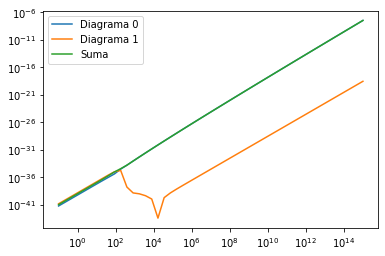

In [70]:
plt.loglog(m6np,y0,label='Diagrama 0')
plt.loglog(m6np,y1,label='Diagrama 1')
plt.loglog(m6np,yt,label='Suma')
plt.legend()

In [26]:
def totaltwo(m6,a,b,quirality='L'):
    return sumatwo(m6,0,a,b,quirality) + sumatwo(m6,1,a,b,quirality)

In [27]:
ALTwoTot23 = lambda m6: totaltwo(m6,2,3,'L')
ARTwoTot23 = lambda m6: totaltwo(m6,2,3,'R')

ALTwoTot32 = lambda m6: totaltwo(m6,3,2,'L')
ARTwoTot32 = lambda m6: totaltwo(m6,3,2,'R')

ALTwoTot13 = lambda m6: totaltwo(m6,1,3,'L')
ARTwoTot13 = lambda m6: totaltwo(m6,1,3,'R')

ALTwoTot31 = lambda m6: totaltwo(m6,3,1,'L')
ARTwoTot31 = lambda m6: totaltwo(m6,3,1,'R')

ALTwoTot12 = lambda m6: totaltwo(m6,1,2,'L')
ARTwoTot12 = lambda m6: totaltwo(m6,1,2,'R')

ALTwoTot21 = lambda m6: totaltwo(m6,2,1,'L')
ARTwoTot21 = lambda m6: totaltwo(m6,2,1,'R')

In [47]:
abs(ALTwoTot23(m6np[-1])),abs(sumatwo(m6np[-1],0,2,3,'L')+ sumatwo(m6np[-1],1,2,3,'L'))

(0.0001309745611596942644862583316971042200416481483506074841717096832050952522516342,
 0.0001309745611596942644862583316971042200416481483506074841717096832050952522516342)

In [140]:
# # a = 2, b = 3
# ALTwoTot23 = numeric_sum_diagramsTwo(2,3,quirality='L')
# ARTwoTot23 = numeric_sum_diagramsTwo(2,3,quirality='R')

# # a = 3, b = 2
# ALTwoTot32 = numeric_sum_diagramsTwo(3,2,quirality='L')
# ARTwoTot32 = numeric_sum_diagramsTwo(3,2,quirality='R')

# # a = 1, b = 3
# ALTwoTot13 = numeric_sum_diagramsTwo(1,3,quirality='L')
# ARTwoTot13 = numeric_sum_diagramsTwo(1,3,quirality='R')

# # a = 3, b = 1
# ALTwoTot31 = numeric_sum_diagramsTwo(3,1,quirality='L')
# ARTwoTot31 = numeric_sum_diagramsTwo(3,1,quirality='R')

# # a = 1, b = 2
# ALTwoTot12 = numeric_sum_diagramsTwo(1,2,quirality='L')
# ARTwoTot12 = numeric_sum_diagramsTwo(1,2,quirality='R')

# # a = 2, b = 1
# ALTwoTot21 = numeric_sum_diagramsTwo(2,1,quirality='L')
# ARTwoTot21 = numeric_sum_diagramsTwo(2,1,quirality='R')

In [52]:
n = 100
expmp = linspace(-1,15,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)
#m6np

In [53]:
YLTwo23 = np.array([factor*abs(ALTwoTot23(m6))**2 for m6 in m6np])
YLTwo32 = np.array([factor*abs(ALTwoTot32(m6))**2 for m6 in m6np])

# YLTwo13 = np.array([factor*abs(ALTwoTot13(m6))**2 for m6 in m6np])
# YLTwo31 = np.array([factor*abs(ALTwoTot31(m6))**2 for m6 in m6np])

# YLTwo12 = np.array([factor*abs(ALTwoTot12(m6))**2 for m6 in m6np])
# YLTwo21 = np.array([factor*abs(ALTwoTot21(m6))**2 for m6 in m6np])

# YLTwo13 = np.array([np.abs(ALTwoTot13(mpf(str(m6)))) for m6 in m6np])
# YLTwo31 = np.array([np.abs(ALTwoTot31(mpf(str(m6)))) for m6 in m6np])

# YLTwo12 = np.array([np.abs(ALTwoTot12(mpf(str(m6)))) for m6 in m6np])
# YLTwo21 = np.array([np.abs(ALTwoTot21(mpf(str(m6)))) for m6 in m6np])

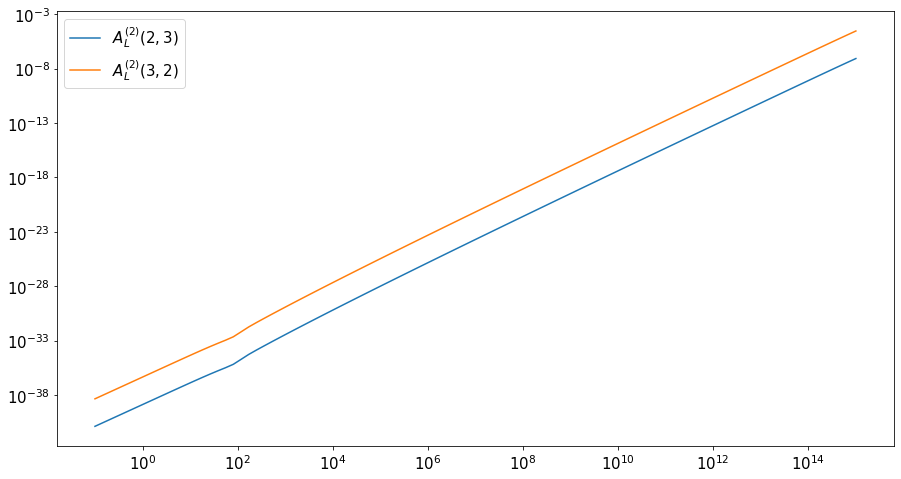

In [54]:
plt.figure(figsize=(15,8))

plt.loglog(m6np,YLTwo23,label='$A_L^{(2)}(2,3)$')
plt.loglog(m6np,YLTwo32,label='$A_L^{(2)}(3,2)$')

# plt.loglog(np.real(m6np),factor*abs(YLTwo13)**2,label='$A_L^{(2)}(1,3)$')
# plt.loglog(np.real(m6np),factor*abs(YLTwo31)**2,label='$A_L^{(2)}(3,1)$')

# plt.loglog(np.real(m6np),factor*abs(YLTwo12)**2,label='$A_L^{(2)}(1,2)$')
# plt.loglog(np.real(m6np),factor*abs(YLTwo21)**2,label='$A_L^{(2)}(2,1)$')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

## Total Form Factors

In [74]:
# #a = 2, b = 3
# ALtot23 =lambda m6: ALOneTot23(mpf(m6))[1] + ALTwoTot23(mpf(m6))
# ARtot23 =lambda m6: AROneTot23(mpf(m6))[1] + ARTwoTot23(mpf(m6))

# #a = 3, b = 2
# ALtot32 =lambda m6: ALOneTot32(mpf(m6))[1] + ALTwoTot32(mpf(m6))
# ARtot32 =lambda m6: AROneTot32(mpf(m6))[1] + ARTwoTot32(mpf(m6))

# #a = 1, b = 3
# ALtot13 =lambda m6: ALOneTot13(mpf(m6))[1] + ALTwoTot13(mpf(m6))
# ARtot13 =lambda m6: AROneTot13(mpf(m6))[1] + ARTwoTot13(mpf(m6))

# #a = 3, b = 1
# ALtot31 =lambda m6: ALOneTot31(mpf(m6))[1] + ALTwoTot31(mpf(m6))
# ARtot31 =lambda m6: AROneTot31(mpf(m6))[1] + ARTwoTot31(mpf(m6))

# #a = 1, b = 2
# ALtot12 =lambda m6: ALOneTot12(mpf(m6))[1] + ALTwoTot12(mpf(m6))
# ARtot12 =lambda m6: AROneTot12(mpf(m6))[1] + ARTwoTot12(mpf(m6))

# #a = 2, b = 1
# ALtot21 =lambda m6: ALOneTot21(mpf(m6))[1] + ALTwoTot21(mpf(m6))
# ARtot21 =lambda m6: AROneTot21(mpf(m6))[1] + ARTwoTot21(mpf(m6))

In [29]:
#a = 2, b = 3
def ALtot23(m6):
    return  ALOneTot23(m6) + ALTwoTot23(m6)
def ARtot23(m6):
    return  AROneTot23(m6) + ARTwoTot23(m6)

#a = 3, b = 2
def ALtot32(m6):
    return  ALOneTot32(m6) + ALTwoTot32(m6)
def ARtot32(m6):
    return  AROneTot32(m6) + ARTwoTot32(m6)

#a = 1, b = 3
def ALtot13(m6):
    return  ALOneTot13(m6) + ALTwoTot13(m6)
def ARtot13(m6):
    return  AROneTot13(m6) + ARTwoTot13(m6)

#a = 3, b = 1
def ALtot31(m6):
    return  ALOneTot31(m6) + ALTwoTot31(m6)
def ARtot31(m6):
    return  AROneTot31(m6) + ARTwoTot31(m6)

#a = 1, b = 2
def ALtot12(m6):
    return  ALOneTot12(m6) + ALTwoTot12(m6)
def ARtot12(m6):
    return  AROneTot12(m6) + ARTwoTot12(m6)

#a = 2, b = 1
def ALtot21(m6):
    return  ALOneTot21(m6) + ALTwoTot21(m6)
def ARtot21(m6):
    return  AROneTot21(m6) + ARTwoTot21(m6)

In [48]:
# plt.figure(figsize=(15,8))
# YLT23 =YLTwo23 + YLTwo32
# YLO23 = YLOne23 + YLOne32
# YL23 = YLT23 + YLO23

# plt.loglog(np.real(m6np),YLO23,label='$A_L^{(1)}(2,3)$')
# plt.loglog(np.real(m6np),YLT23,label='$A_L^{(2)}(2,3)$')
# plt.loglog(np.real(m6np),YL23,label='$A_L(2,3)$')


# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# plt.legend(fontsize=15)

## Width decay of $h \to e_a e_b$

In [30]:
from OneLoopLFVHD import Γhlilj

In [31]:
def Γhl2l3(m6):
    return Γhlilj(ALtot23(m6),ARtot23(m6),valores[mh],ml[2],ml[3])
def Γhl3l2(m6):
    return Γhlilj(ALtot32(m6),ARtot32(m6),valores[mh],ml[3],ml[2])

def Γhl1l3(m6):
    return Γhlilj(ALtot13(m6),ARtot13(m6),valores[mh],ml[1],ml[3])
def Γhl3l1(m6):
    return Γhlilj(ALtot31(m6),ARtot31(m6),valores[mh],ml[3],ml[1])

def Γhl1l2(m6):
    return Γhlilj(ALtot12(m6),ARtot12(m6),valores[mh],ml[1],ml[2])
def Γhl2l1(m6):
    return Γhlilj(ALtot21(m6),ARtot21(m6),valores[mh],ml[2],ml[1])

In [39]:
n = 300
expmp = linspace(-1,15,n)
m6np = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)

In [78]:
# YW23 = np.array([Γhlilj(ALtot23(m6),ARtot23(m6),valores[mh],ml[2],ml[3]) for m6 in m6np])
# YW32 = np.array([Γhlilj(ALtot32(m6),ARtot32(m6),valores[mh],ml[3],ml[2]) for m6 in m6np])

# YW13 = np.array([Γhlilj(ALtot13(m6),ARtot13(m6),valores[mh],ml[1],ml[3]) for m6 in m6np])
# YW31 = np.array([Γhlilj(ALtot31(m6),ARtot31(m6),valores[mh],ml[3],ml[1]) for m6 in m6np])

# YW12 = np.array([Γhlilj(ALtot12(m6),ARtot12(m6),valores[mh],ml[1],ml[2]) for m6 in m6np])
# YW21 = np.array([Γhlilj(ALtot21(m6),ARtot21(m6),valores[mh],ml[2],ml[1]) for m6 in m6np])

In [40]:
%%time
YW23 = speedup_array(Γhl2l3,m6np)
#YW32 = speedup_array(Γhl3l2,m6np)

YW13 = speedup_array(Γhl1l3,m6np)
#YW31 = speedup_array(Γhl3l1,m6np)

YW12 = speedup_array(Γhl1l2,m6np)

#YW21 = speedup_array(Γhl2l1,m6np)

CPU times: user 5.07 s, sys: 2.93 s, total: 8 s
Wall time: 49min 42s


In [86]:
#Γhlilj = lambda mh,AL,AR: mh/(8*pi)*(abs(AL)**2 + abs(AR)**2)

In [87]:
# n = 100
# m6np = np.logspace(-1,15,n)
# #m6np = np.linspace(1e-1,1e15,n)

# YW23 = np.array([Γhlilj(valores[mh],ALtot23(m6),ARtot23(m6)) for m6 in m6np])
# YW32 = np.array([Γhlilj(valores[mh],ALtot32(m6),ARtot32(m6)) for m6 in m6np])

# YW13 = np.array([Γhlilj(valores[mh],ALtot13(m6),ARtot13(m6)) for m6 in m6np])
# YW31 = np.array([Γhlilj(valores[mh],ALtot31(m6),ARtot31(m6)) for m6 in m6np])

# YW12 = np.array([Γhlilj(valores[mh],ALtot12(m6),ARtot12(m6)) for m6 in m6np])
# YW21 = np.array([Γhlilj(valores[mh],ALtot21(m6),ARtot21(m6)) for m6 in m6np])

In [41]:
Wtot = YW23 + YW13 + YW12 + 0.0032# + YW32 + YW31 + YW21

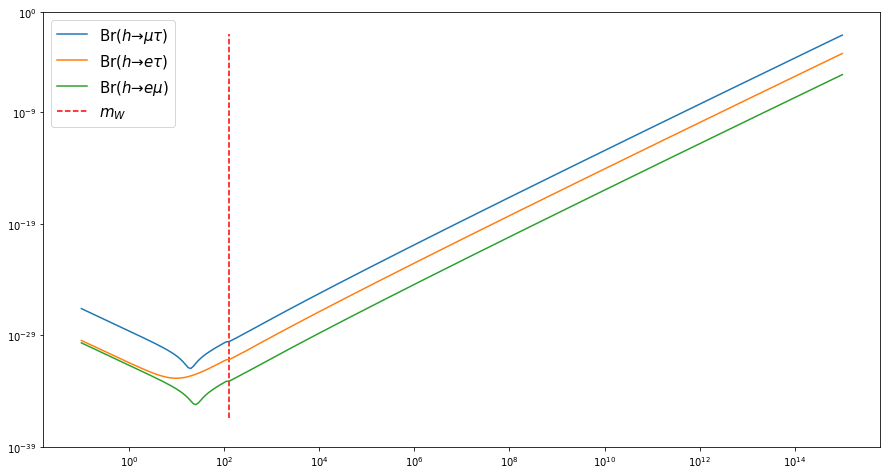

In [43]:
plt.figure(figsize=(15,8))
plt.loglog(np.real(m6np),(YW23 #+ YW32
                         )/Wtot,label=r'Br($h \to \mu \tau$)')
plt.loglog(np.real(m6np),(YW13 #+ YW31
                         )/Wtot,label=r'Br($h \to e \tau$)')
plt.loglog(np.real(m6np),(YW12 #+ YW21
                         )/Wtot,label=r'Br($h \to e \mu$)')

#xx = ((YW23 + YW32)/Wtot)[-1]
#plt.hlines(0.017,0.1,1e15,linestyles='-.',label=r'$1.7\times 10^{-2}$')
#plt.hlines(1e-34,0.1,1e15,linestyles='--',color='b',label=r'$1\times 10^{-32}$')
plt.vlines(125.1,4e-37,1e-2,linestyles='--',color='r',label=r'$m_W$')
#plt.ylim(1e-49,1)
plt.yticks([1e-39,1e-29,1e-19,1e-9,1])
plt.legend(fontsize=15)

In [59]:
import pandas as pd

In [60]:
df = pd.DataFrame({'m6':m6np,'Whl2l3':YW23,'Whl3l2':YW32,'Whl1l3':YW13,'Whl3l1':YW31,
                   'Whl1l2':YW12,'Whl2l1':YW21})

In [61]:
df.to_csv('LFVHD.txt',sep='\t')

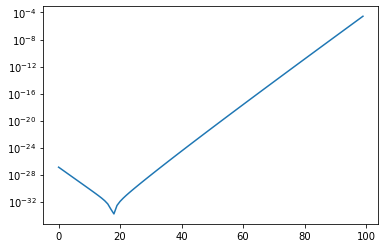

In [56]:
plt.semilogy(np.array(list(map(mpf,df['Whl2l3']))))